In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/EPFL HS21/Machine Learning CS-433/projects/ML team project/Project 2 

Mounted at /content/drive
/content/drive/MyDrive/EPFL HS21/Machine Learning CS-433/projects/ML team project/Project 2


In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7 MB 27.9 MB/s 


In [ ]:
import cv2
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

import skimage.color
import skimage.io
import skimage.measure

In [ ]:
#DATA_PATH = '/content/drive/My Drive/ML team project/Project' #Nico
DATA_PATH = '/content/drive/MyDrive/EPFL HS21/Machine Learning CS-433/projects/ML team project/Project 2/cell-data/datasets/droplets' #Ruben
MODEL_PATH = '/content/drive/MyDrive/EPFL HS21/Machine Learning CS-433/projects/ML team project/Project 2' #Ruben
BEST_PARAMS = {'dp':2, 'minRadius':20, 'maxRadius':50, 'param2':90, 'param1':100, 'minDist':30}

# Droplet Detector

In [ ]:
def is_cropped(shape, coords):
    y, x, r = coords
    max_x, max_y = shape
    
    top = (y - r) < 0
    left = (x - r) < 0
    bot = (y + r) > max_y
    right = (x + r) > max_x
    
    if top or left or bot or right:
        return True
    else:
        return False

#Function used to detect circles using cv2
def find_circles(image, **kwargs):
    output = image.copy()
    
    #Bottom 20 pixels of the image contain text, so we remove it
    image = image[0:1024,:]
    #Apply Gaussian Blur. Doing this allows us to increase the 'dp' parameter of the 
    #HoughCircles function, without increasing the number of False circles detected.
    #This means we end up finding more circles overall
    image = cv2.GaussianBlur(image, (3,3),3)
    
    #Find the circles
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, **kwargs)
    
    #Annotate them on the image
    c = np.round(circles[0, :]).astype("int")
    edge_inds = []
    # loop over the (x, y) coordinates and radius of the circles
    for i, (x, y, r) in enumerate(c):
        if is_cropped(image.shape, (x,y,r)):
            edge_inds.append(i)
            continue
    
        # draw the circle in the output image
        cv2.circle(output, (x, y), r, (0, 0, 255), 4)
    #Return annotated image and circles
    c = np.delete(c, edge_inds, axis=0)
    return output, c



# Droplet Extraction

In [ ]:
def create_circular_mask(shape, center=None, radius=None):
    h, w = shape
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def extract_droplet(im, coords):
    y, x, r = coords
    r = int(0.9*r)
    droplet = im[x-r:x+r, y-r:y+r].copy()
    mask = create_circular_mask(droplet.shape)
    droplet[~mask] = 0
    
    return droplet

def extract_droplets(im, circles):
    droplets = []
    for c in circles:
        droplet = extract_droplet(im, c)
        droplets.append(droplet)
    return droplets

# Droplet Classification

In [ ]:
#Helper functions
def standardize_matrix(matrix):
   return (matrix - np.mean(matrix)) / np.std(matrix)

def preprocess_image(image):
  image = skimage.measure.block_reduce(image, (2,2), np.min) #min pooling to accentuate dark items
  image = image[image != 0] #renove pure black (0) pixels
  image = image[image > 30] #renove dark pixels that are less than 20 (very dark colours that are likely shadows)
  image = image[image <= 240] #remove pure white (255) pixels
  return image.ravel()

def preprocess_image_secondary_split(image):
  image = skimage.measure.block_reduce(image, (2,2), np.max) #min pooling to accentuate dark items
  image = image[image != 0] #renove pure black (0) pixels
  image = image[image > 30] #renove dark pixels that are less than 20 (very dark colours that are likely shadows)
  image = image[image <= 240] #remove pure white (255) pixels
  median_norm = image-np.median(image)
  standard_median_norm = standardize_matrix(median_norm)
  metric = np.percentile(standard_median_norm, q=10) - np.median(standard_median_norm)
  return metric.ravel()

def bincount(a):
    y = np.bincount(a)
    ii = np.nonzero(y)[0]
    return np.vstack((ii, y[ii])).T

In [ ]:
def get_all_filenames_in_folder(folder_path):
  #returns only files, not folders
  return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and ".jpg" in f]

In [ ]:
# CLASSIFICATION STAGE 1
# The "initial split" that will determine if the images belong to either:
# 0. empty droplets
# 1. full droplets OR empty droplets with noise (will have to be futher classified for robustness to noise)
def get_initial_prediction_split(images):
  centroid_difference_acc = np.array([])
  initial_predictions = np.array([])
  for image in images:
    #processs image
    preprocessed_image = preprocess_image(image).reshape(-1, 1)

    #initialize model 2 clusters
    individual_model = KMeans(n_clusters=2, random_state=123)

    #train model 2 clusters
    individual_model.fit(preprocessed_image)

    #get model centroids information
    model_centroids = individual_model.cluster_centers_.ravel().tolist()
    centroid_difference = max(model_centroids) - min(model_centroids)
    centroid_difference_acc = np.append(centroid_difference_acc, centroid_difference) #accumulate all centroids in an array to cluster them
  #plt.hist(centroid_difference_acc, bins = 100)
  
  #clustering model on the centroid_differences to find the optimal thresholds (KMEDOIDS)
  initial_split_model = pickle.load(open(os.path.join(MODEL_PATH, "initial_split_model_KMedoids.pkl"), "rb"))
  prediction_initial_split = initial_split_model.predict(centroid_difference_acc.reshape(-1, 1))
  prediction_initial_split = initial_split_model.predict(centroid_difference_acc.reshape(-1, 1))

  #get model cluster centers and their values
  model_centroids_initial_split = initial_split_model.cluster_centers_.ravel().tolist()
  model_centroids_initial_split_min_value = min(model_centroids_initial_split)
  model_centroids_initial_split_min_class = model_centroids_initial_split.index(model_centroids_initial_split_min_value)
  model_centroids_initial_split_max_value = max(model_centroids_initial_split)
  model_centroids_initial_split_max_class = model_centroids_initial_split.index(model_centroids_initial_split_max_value)

  for pred in prediction_initial_split:
    if pred == model_centroids_initial_split_min_class:
      # intially classified empty droplets do not have to be further processed
      label = 0
    else:
      # initially classified "full" droplets have to be reprocessed for robustness to noise (done in another function)
      label = 1
    initial_predictions = np.append(initial_predictions, label)
  return initial_predictions #array of predicted labels (0=empty, 1=full or empty with noise)

In [ ]:
def classify_droplets(droplets):
  #folder_path -> the path of the folder on which the images have to be classified

  #make predictions from the images in folder_path
    images = droplets
    initial_predictions = get_initial_prediction_split(images)

    return initial_predictions
    #make a copy of files into folder_path_destination for visual inspection
    list_of_file_names = get_all_filenames_in_folder(folder_path)
    counter = 0
    for file_name, prediction in zip(list_of_file_names, initial_predictions): #iterate through all the files in the specified folder
        file_path = folder_path + "/" + file_name

        #save image
        destination_file_path = folder_path_destination + "/" + str(int(prediction)) + "_" + str(counter) + ".jpg"
        shutil.copy(file_path, destination_file_path)

        counter += 1

# Annotate image

In [ ]:
# Helper functions

#annotate image header with Total, Empty and Full counts
def annotate_counts(im, preds):
    total = len(preds)
    empty = sum(preds==0)
    full = sum(preds==1)

    text_matrix = 255*np.ones((250,1280, 3), dtype=np.uint8)
    text_matrix = cv2.putText(text_matrix, f'Total Droplets: {total}', (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 2, color=(0,0,0), thickness=3)
    text_matrix = cv2.putText(text_matrix, f'Empty Droplets (Red): {empty}', (25, 145), cv2.FONT_HERSHEY_SIMPLEX, 2, color=(0,0,255), thickness=3)
    text_matrix = cv2.putText(text_matrix, f'Full Droplets (Blue): {full}', (25, 220), cv2.FONT_HERSHEY_SIMPLEX, 2, color=(255,0,0), thickness=3)
    return np.vstack([text_matrix, im]), total, empty, full

In [ ]:
def annotate_images(folder_path):
  excel_file_df = pd.DataFrame([], columns=['filename', 'total', 'empty', 'full'])
  #get all files to annotate
  all_file_paths = get_all_filenames_in_folder(folder_path) #["bacteria-3h20B0000000000.jpg"] 
  print("Number of images to be annotated: ", len(all_file_paths))

  for filename in all_file_paths:
    print("Annotating: ", filename)

    #get prediction for each droplet of the image
    image = cv2.imread(os.path.join(folder_path, filename), 0)
    _, circles = find_circles(image, **BEST_PARAMS)

    droplets = extract_droplets(image, circles)
    preds = classify_droplets(droplets)
    preds[preds<=0] = 0
    preds[preds>=1] = 1

    #colour circles on the image
    image_rgb = np.dstack([image,image,image])
    for p, coord in zip(preds, circles):
        x, y, r = coord
        colour = (255, 0, 0) if p else (0, 0, 255)
        cv2.circle(image_rgb, (x, y), r, colour, 4)

    #annotate image header and save image
    annotated_image, total, empty, full = annotate_counts(image_rgb, preds)
    plt.imshow(annotated_image)
    ann_file = filename[:-4] + '_annotated.jpg'
    cv2.imwrite(os.path.join(MODEL_PATH, 'annotated_images', ann_file), annotated_image)
    #add row to excel file
    excel_file_df.loc[len(excel_file_df)]= [filename, total, empty, full]
  
  #write excel file
  from datetime import datetime
  now = datetime.now()
  excel_file_df.to_excel("annotated_images_summary_{}.xlsx".format(str(now)))

Number of images to be annotated:  67
Annotating:  2 hrs bacteria only A0000000000.jpg


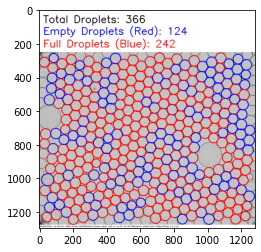

In [ ]:
annotate_images(DATA_PATH)

## Other utilities for visualization and testing

In [ ]:
#filename = 'bacteria-phage025_5hrs_040000000000.jpg'
#filename = 'bacteria-phage_control_5hrs_020000000000.jpg'
#filename = 'bacteria-phaage05-2h0000000000.jpg'
filename = 'LB FOS lambda 10 3.jpg'
image = cv2.imread(os.path.join(DATA_PATH, filename), 0)
_, circles = find_circles(image, **BEST_PARAMS)

droplets = extract_droplets(image, circles)
preds = classify_droplets(droplets)
preds[preds<=1] = 0
preds[preds==2] = 1

Initial split model centroids:  [5.711734061027045, 24.512209302325573]
Secondary split model centroids:  [-0.9509051532723173, -1.3922742059670346]


In [ ]:
image_rgb = np.dstack([image,image,image])
for p, coord in zip(preds, circles):
    x, y, r = coord
    colour = (255, 0, 0) if p else (0, 0, 255)
    cv2.circle(image_rgb, (x, y), r, colour, 4)

True

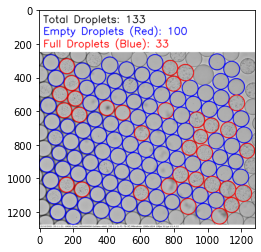

In [ ]:
# annotate images
annotated_image = annotate_counts(image_rgb, preds)
plt.imshow(annotated_image)
ann_file = filename[:-4] + '_annotated.jpg'
cv2.imwrite(os.path.join(MODEL_PATH, 'annotated_images', ann_file), annotated_image)